# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [ ]:
!pip install pycrf
!pip install sklearn-crfsuite

# Installing scikit-learn 0.23.1 to make it compatible with sklearn-crfsuite and ignoring the error for this experiment
!pip install scikit-learn==0.23.1 

import pandas as pd
import numpy as np
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import re
from spacy.tokenizer import Tokenizer

from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER
from spacy.lang.char_classes import CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS
from spacy.util import compile_infix_regex

import scipy
import scipy.stats
from sklearn.metrics import make_scorer
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn_crfsuite.metrics import flat_classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=f174925b98908d0c58557d02728010b14f22c6bfce58e39d602e65b0d3dd6313
  Stored in directory: /root/.cache/pip/wheels/0b/68/37/a457e156cfd6174ed28c9c8cb76f18eeb559b760d84c0a22eb
Successfully built pycrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 6.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 8.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

In [ ]:
from google.colab import drive
from glob import glob

In [ ]:
## mounting the google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Loading the spacy model 'en_core_web_sm' and disbaling the parser and ner in the spacy pipeline to get quick results from the spacy model. 

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

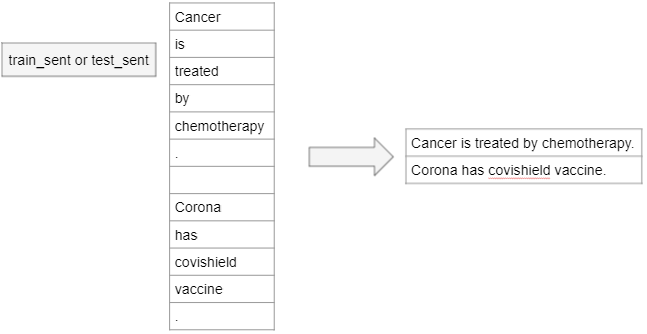

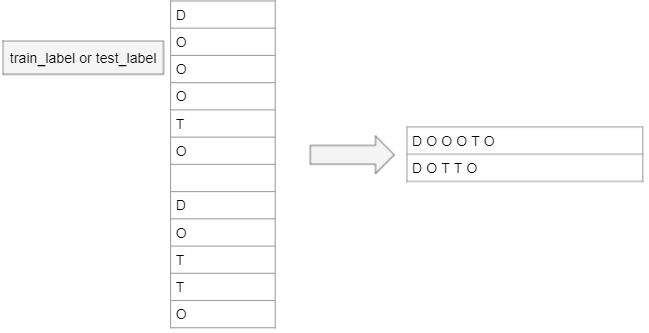

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Syntactical_Processing_NER_CRF/Assignment/train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('/content/gdrive/MyDrive/Colab Notebooks/Syntactical_Processing_NER_CRF/Assignment/train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('/content/gdrive/MyDrive/Colab Notebooks/Syntactical_Processing_NER_CRF/Assignment/test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('/content/gdrive/MyDrive/Colab Notebooks/Syntactical_Processing_NER_CRF/Assignment/test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [ ]:
# Let's take a look at the train dataset
train_sentences[50:150]

['was\n',
 '14.4\n',
 '%\n',
 '(\n',
 '344\n',
 'of\n',
 '2395\n',
 ')\n',
 ',\n',
 'and\n',
 'the\n',
 'primary\n',
 'rate\n',
 'was\n',
 '11.4\n',
 '%\n',
 '(\n',
 '244\n',
 'of\n',
 '2144\n',
 ')\n',
 '\n',
 'Abnormal\n',
 'presentation\n',
 'was\n',
 'the\n',
 'most\n',
 'common\n',
 'indication\n',
 '(\n',
 '25.6\n',
 '%\n',
 ',\n',
 '88\n',
 'of\n',
 '344\n',
 ')\n',
 '\n',
 'The\n',
 '``\n',
 'corrected\n',
 "''\n",
 'cesarean\n',
 'rate\n',
 '(\n',
 'maternal-fetal\n',
 'medicine\n',
 'and\n',
 'transported\n',
 'patients\n',
 'excluded\n',
 ')\n',
 'was\n',
 '12.4\n',
 '%\n',
 '(\n',
 '273\n',
 'of\n',
 '2194\n',
 ')\n',
 ',\n',
 'and\n',
 'the\n',
 '``\n',
 'corrected\n',
 "''\n",
 'primary\n',
 'rate\n',
 'was\n',
 '9.6\n',
 '%\n',
 '(\n',
 '190\n',
 'of\n',
 '1975\n',
 ')\n',
 '\n',
 'Arrest\n',
 'of\n',
 'dilation\n',
 'was\n',
 'the\n',
 'most\n',
 'common\n',
 'indication\n',
 'in\n',
 'both\n',
 '``\n',
 'corrected\n',
 "''\n",
 'subgroups\n',
 '(\n',
 '23.4\n',
 'and\n

## **Adding Custom tokenzier**

### Spacy Custom Tokenizer to help POS tagging process. Without this custom tokenizer, the workd like 'New-York' was treated like three seprate tokens, 'New', '-' and 'York'.

In [ ]:
special_cases = {":)": [{"ORTH": ":)"}]}
infix_re = re.compile(r'''[-~]''')
simple_url_re = re.compile(r'''^https?://''')

# Modify tokenizer infix patterns
infixes = (
    LIST_ELLIPSES
    + LIST_ICONS
    + [
        r"(?<=[0-9])[+\-\*^](?=[0-9-])",
        r"(?<=[{al}{q}])\.(?=[{au}{q}])".format(
            al=ALPHA_LOWER, au=ALPHA_UPPER, q=CONCAT_QUOTES
        ),
        r"(?<=[{a}]),(?=[{a}])".format(a=ALPHA),
        r"(?<=[{a}0-9])[:<>=](?=[{a}])".format(a=ALPHA),
    ]
)

infix_re = compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_re.finditer

def custom_tokenizer(nlp):
    return Tokenizer(nlp.vocab, rules=special_cases,
                                url_match=simple_url_re.match)


nlp.tokenizer = custom_tokenizer(nlp)

## Process the raw data
- Remove the new line charaters
- Decide the a sentence boundary and join individual words into sentences
- Appy POS tagging on every sentence. Before Taging we have applied custom tokenizer as well to handle edge cases of tokenization
- Finally retuning 
    - a dictionary with key as sentnce id and values are the list of sentences and values
    - a list of sentences, labels and pos tags for each sentence

In [ ]:
def process_data(sentences, labels):
    sent_label_dict = {}
    sentence = []
    sentence_list = []
    label_list = []
    label = []
    sent_pos_tag_list = []
    sent_counter = 1
    for i in range(len(sentences)):
        if sentences[i].split('\n')[0] != '':
            sentence.append(sentences[i].split('\n')[0])
            label.append(labels[i].split('\n')[0])
        else:
            k = "sentence-"+str(sent_counter)
            sentence_list.append(' '.join(sentence))
            label_list.append(label)
            sent_label_dict[k] = (sentence, label)
            
            
            
            doc = nlp(' '.join(sentence))
            sent_pos_tag = []
            for tok in doc:
                sent_pos_tag.append(tok.pos_)
            sent_pos_tag_list.append(sent_pos_tag)
            sent_counter = sent_counter +1
            sentence = []
            label = []

    return sent_label_dict, sentence_list, label_list, sent_pos_tag_list

### Getting the processed train data and then printing first five statements and corresponding labels

In [ ]:
train_data_dict, train_sentence_list, train_label_list, train_sent_pos_tag_list= process_data(train_sentences, train_labels)
print("Below is the list of first five train sentences and correspoding label")
for i in range(5):
    k = "sentence-"+str(i+1)
    print(k)
    print("##################################")
    print((' '.join(train_data_dict[k][0])))
    print((train_data_dict[k][1]))



Below is the list of first five train sentences and correspoding label
sentence-1
##################################
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sentence-2
##################################
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sentence-3
##################################
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
['O', 'O', 'O', 'O', 'O', 'O',

### Getting the processed test data and then printing first five statements and corresponding labels

In [ ]:
test_data_dict, test_sentence_list, test_label_list, test_sent_pos_tag_list= process_data(test_sentences, test_labels)
print("Below is the list of first five test sentences and correspoding label")
for i in range(5):
    k = "sentence-"+str(i+1)
    print(k)
    print("##################################")
    print((' '.join(test_data_dict[k][0])))
    print((test_data_dict[k][1]))

Below is the list of first five test sentences and correspoding label
sentence-1
##################################
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sentence-2
##################################
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sentence-3
##################################
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
['O', 'O', 'O', 'O', 'O', 

### Count the number of sentences in the processed train and test dataset 

In [ ]:
print(f"The number of sentences in processed train data is", len(train_sentence_list))
print(f"The number of sentences in processed test data is", len(test_sentence_list))

The number of sentences in processed train data is 2599
The number of sentences in processed test data is 1056


### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
print(f"The number of lines of labels in processed train data is", len(train_label_list))
print(f"The number of lines of labels in processed test data is", len(test_label_list))

The number of lines of labels in processed train data is 2599
The number of lines of labels in processed test data is 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
def generate_dataframes(sentence_list, sent_pos_tag_list, label_list, data_type):
    for i in range(len(sentence_list)):
        data_1 = {
        'Sentence': data_type + "-sentence-" + str(i+1),
        'Token': sentence_list[i].split(),
        'POS_TAG': sent_pos_tag_list[i],
        'Label': label_list[i]
        }
        if i == 0:
            dataset = pd.DataFrame(data_1)
        else:
            dataset_1 = pd.DataFrame(data_1)
            dataset = pd.concat([dataset,dataset_1])
    return dataset

In [ ]:
train_dataset = generate_dataframes(train_sentence_list, train_sent_pos_tag_list, train_label_list, 'train')
train_dataset.head()

,Sentence,Token,POS_TAG,Label
0,train-sentence-1,All,DET,O
1,train-sentence-1,live,ADJ,O
2,train-sentence-1,births,NOUN,O
3,train-sentence-1,>,X,O
4,train-sentence-1,or,CCONJ,O


In [ ]:
test_dataset = generate_dataframes(test_sentence_list, test_sent_pos_tag_list, test_label_list, 'test')
test_dataset.head()

,Sentence,Token,POS_TAG,Label
0,test-sentence-1,Furthermore,ADV,O
1,test-sentence-1,",",PUNCT,O
2,test-sentence-1,when,SCONJ,O
3,test-sentence-1,all,DET,O
4,test-sentence-1,deliveries,NOUN,O


In [ ]:
# conatinating the complete train and test data to get the frequency of the NOUN and PROPN pos tag
dataset = pd.concat([train_dataset,test_dataset])

#### Plotting a bar chart for getting the frequency of all the POS tags 

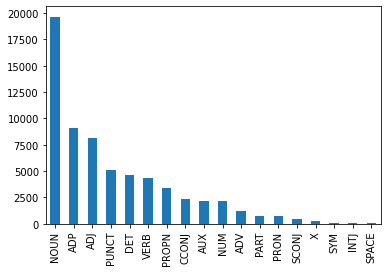

In [ ]:
dataset['POS_TAG'].value_counts().plot(kind='bar')

In [ ]:
#Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


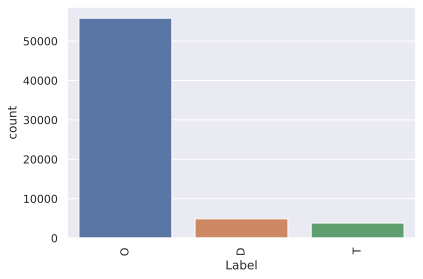

In [ ]:
#Words distribution across Tags
#plt.figure(figsize=(15, 5))
ax = sns.countplot('Label', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


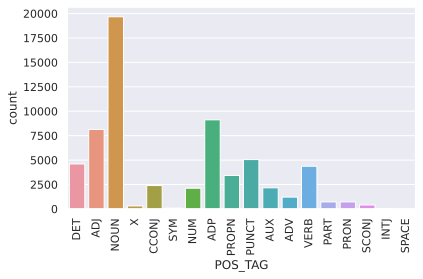

In [ ]:
#Words distribution across POS
#plt.figure(figsize=(15, 5))
ax = sns.countplot('POS_TAG', data=dataset, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
# Generating a dataset having takens which are either NOUN or PROPN
data_Tok_Pos = dataset[(dataset['POS_TAG']=='NOUN') | (dataset['POS_TAG']=='PROPN')]
data_Tok_Pos = data_Tok_Pos.drop(['Sentence', 'Label'], axis=1)
data_Tok_Pos = data_Tok_Pos.reset_index(drop=True)
data_Tok_Pos.head()

,Token,POS_TAG
0,births,NOUN
1,weeks,NOUN
2,University,PROPN
3,Vermont,PROPN
4,delivery,NOUN


### Below is the list of first top (based on fruency of occurence) 25 Noun/PPROPN POS tag words

In [ ]:
data_group_by_tok = data_Tok_Pos.groupby(data_Tok_Pos.columns.tolist(),as_index=False).size()
data_group_by_tok = data_group_by_tok.sort_values(by=['size'], ascending=False)
data_group_by_tok = data_group_by_tok.reset_index(drop=True)
data_group_by_tok.head(25)

,Token,POS_TAG,size
0,patients,NOUN,492
1,treatment,NOUN,280
2,%,NOUN,247
3,cancer,NOUN,199
4,therapy,NOUN,175
5,study,NOUN,154
6,disease,NOUN,136
7,lung,NOUN,113
8,cell,NOUN,103
9,chemotherapy,NOUN,88


In [ ]:
classes = dataset.Label.unique()
classes = classes.tolist()

## Formating the input data to be used by CRF model





In [ ]:
class SentenceGetter():
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Token'].values.tolist(), 
                                                           s['POS_TAG'].values.tolist(), 
                                                           s['Label'].values.tolist())]
        self.grouped = self.data.groupby('Sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [ ]:
getter = SentenceGetter(train_dataset)
train_sentences = getter.sentences
train_sentences

[[('All', 'DET', 'O'),
  ('live', 'ADJ', 'O'),
  ('births', 'NOUN', 'O'),
  ('>', 'X', 'O'),
  ('or', 'CCONJ', 'O'),
  ('=', 'SYM', 'O'),
  ('23', 'NUM', 'O'),
  ('weeks', 'NOUN', 'O'),
  ('at', 'ADP', 'O'),
  ('the', 'DET', 'O'),
  ('University', 'PROPN', 'O'),
  ('of', 'ADP', 'O'),
  ('Vermont', 'PROPN', 'O'),
  ('in', 'ADP', 'O'),
  ('1995', 'NUM', 'O'),
  ('(', 'PUNCT', 'O'),
  ('n', 'ADP', 'O'),
  ('=', 'X', 'O'),
  ('2395', 'NUM', 'O'),
  (')', 'PUNCT', 'O'),
  ('were', 'AUX', 'O'),
  ('retrospectively', 'ADV', 'O'),
  ('analyzed', 'VERB', 'O'),
  ('for', 'ADP', 'O'),
  ('delivery', 'NOUN', 'O'),
  ('route', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('indication', 'NOUN', 'O'),
  ('for', 'ADP', 'O'),
  ('cesarean', 'PROPN', 'O'),
  (',', 'PUNCT', 'O'),
  ('gestational', 'ADJ', 'O'),
  ('age', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('parity', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('and', 'CCONJ', 'O'),
  ('practice', 'NOUN', 'O'),
  ('group', 'NOUN', 'O'),
  ('(', 'PUNCT', 'O'),
  (

#### Confirming the count of train data after formatting

In [ ]:
len(train_sentences)

2599

In [ ]:
train_sentences[1]

[('The', 'DET', 'O'),
 ('daily', 'ADJ', 'O'),
 ('high', 'ADJ', 'O'),
 ('ambient', 'ADJ', 'O'),
 ('temperature', 'NOUN', 'O'),
 ('in', 'ADP', 'O'),
 ('our', 'PRON', 'O'),
 ('urban', 'ADJ', 'O'),
 ('area', 'NOUN', 'O'),
 ('was', 'AUX', 'O'),
 ('subsequently', 'ADV', 'O'),
 ('obtained', 'VERB', 'O')]

In [ ]:
getter = SentenceGetter(test_dataset)
test_sentences = getter.sentences
test_sentences

[[('Furthermore', 'ADV', 'O'),
  (',', 'PUNCT', 'O'),
  ('when', 'SCONJ', 'O'),
  ('all', 'DET', 'O'),
  ('deliveries', 'NOUN', 'O'),
  ('were', 'AUX', 'O'),
  ('analyzed', 'VERB', 'O'),
  (',', 'PUNCT', 'O'),
  ('regardless', 'ADV', 'O'),
  ('of', 'ADP', 'O'),
  ('risk', 'NOUN', 'O'),
  ('status', 'NOUN', 'O'),
  ('but', 'CCONJ', 'O'),
  ('limited', 'ADJ', 'O'),
  ('to', 'ADP', 'O'),
  ('gestational', 'ADJ', 'O'),
  ('age', 'NOUN', 'O'),
  ('>', 'X', 'O'),
  ('or', 'CCONJ', 'O'),
  ('=', 'SYM', 'O'),
  ('36', 'NUM', 'O'),
  ('weeks', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('the', 'DET', 'O'),
  ('rates', 'NOUN', 'O'),
  ('did', 'AUX', 'O'),
  ('not', 'PART', 'O'),
  ('change', 'VERB', 'O'),
  ('(', 'PUNCT', 'O'),
  ('12.6', 'NUM', 'O'),
  ('%', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('280', 'NUM', 'O'),
  ('of', 'ADP', 'O'),
  ('2214', 'NUM', 'O'),
  (';', 'PUNCT', 'O'),
  ('primary', 'ADJ', 'O'),
  ('9.2', 'NUM', 'O'),
  ('%', 'NOUN', 'O'),
  (',', 'PUNCT', 'O'),
  ('183', 'NUM', 'O'

#### Confirming the count of test data after formatting

In [ ]:
len(test_sentences)

1056

In [ ]:
test_sentences[1]

[('All', 'ADV', 'O'),
 ('together', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('27', 'NUM', 'O'),
 ('fetuses', 'NOUN', 'O'),
 ('had', 'AUX', 'O'),
 ('this', 'DET', 'O'),
 ('disorder', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('representing', 'VERB', 'O'),
 ('28.7', 'NUM', 'O'),
 ('%', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('27', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('94', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('of', 'ADP', 'O'),
 ('all', 'DET', 'O'),
 ('cytogenetic', 'ADJ', 'D'),
 ('aberrations', 'NOUN', 'D'),
 ('detected', 'VERB', 'O'),
 ('at', 'ADP', 'O'),
 ('our', 'PRON', 'O'),
 ('center', 'NOUN', 'O'),
 ('over', 'ADP', 'O'),
 ('the', 'DET', 'O'),
 ('same', 'ADJ', 'O'),
 ('period', 'NOUN', 'O')]

## Getting the features

### Let's define a method to get the feature set of single word

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            #'-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            #'+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2tokens(sent):
    return [token for token, postag, label in sent]

### Write a code/function to get the features for a sentence

In [ ]:
# Code to get features for a sentence.
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### Write a code/function to get the labels of a sentence

In [ ]:
# Code to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

In [ ]:
sent2features(train_sentences[1])

[{'bias': 1.0,
  'word.lower()': 'the',
  'word[-3:]': 'The',
  'word[-2:]': 'he',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'postag': 'DET',
  'postag[:2]': 'DE',
  'BOS': True,
  '+1:word.lower()': 'daily',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'ADJ'},
 {'bias': 1.0,
  'word.lower()': 'daily',
  'word[-3:]': 'ily',
  'word[-2:]': 'ly',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'ADJ',
  'postag[:2]': 'AD',
  '-1:word.lower()': 'the',
  '-1:word.istitle()': True,
  '-1:word.isupper()': False,
  '-1:postag': 'DET',
  '+1:word.lower()': 'high',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'ADJ'},
 {'bias': 1.0,
  'word.lower()': 'high',
  'word[-3:]': 'igh',
  'word[-2:]': 'gh',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'ADJ',
  'postag[:2]': 'AD',
  '-1:word.lower()': 'daily',
  '-

In [ ]:
sent2labels(train_sentences[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

### Define the labels as the target variable for test and the train dataset

In [ ]:
X_train = [sent2features(s) for s in train_sentences]
y_train = [sent2labels(s) for s in train_sentences]

In [ ]:
X_test = [sent2features(s) for s in test_sentences]
y_test = [sent2labels(s) for s in test_sentences]

## Build the CRF Model

### **Note:** crf fit() method is throwing Attribute error with sklearn >= 0.24 as per it's error logged in github. SO, I have installed sklearn 0.23.1 in colab environment to make it work. Otherwise I was not able to run hyperparameter tuning code for the same with Attribute Error except block. 

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.211521115,
    c2=0.000017662,
    max_iterations=100,
    all_possible_transitions=True
)

#try:
crf.fit(X_train, y_train)
#except AttributeError:
#    pass

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.211521115,
    c2=1.7662e-05, keep_tempfiles=None, max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9287750978970154

In [ ]:
print(metrics.flat_classification_report(y_test, y_pred, labels = classes))

              precision    recall  f1-score   support

           O       0.95      0.98      0.96     16127
           D       0.82      0.68      0.74      1450
           T       0.75      0.61      0.67      1041

    accuracy                           0.93     18618
   macro avg       0.84      0.75      0.79     18618
weighted avg       0.93      0.93      0.93     18618



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['O', 'D', 'T'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### The above crf model is the best model I got during my experimentation. The best f1_score I got is 93%. 
### We will use same model further in the code for any evaluation. 

In [ ]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 10
print("Sentence:",test_sentences[id])
print("Orig Labels:", y_test[id])
print("Pred Labels:", y_pred[id])

Sentence: [('The', 'DET', 'O'), ('treatment', 'NOUN', 'O'), ('of', 'ADP', 'O'), ('autoimmune', 'ADJ', 'D'), ('hemolytic', 'ADJ', 'D'), ('anemia', 'NOUN', 'D'), ('with', 'ADP', 'O'), ('heparin', 'NOUN', 'T')]
Orig Labels: ['O', 'O', 'O', 'D', 'D', 'D', 'O', 'T']
Pred Labels: ['O', 'O', 'O', 'D', 'D', 'D', 'O', 'T']


In [ ]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 468
print("Sentence:",test_sentences[id][-7][0])
print("Orig Labels:", y_test[id])
print("Pred Labels:", y_pred[id])

Sentence: retinoblastoma
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'O', 'O', 'O', 'O', 'T']


### Let's try the hyperparameter tuning for the crf model and see the stability of the model we are getting

In [ ]:
#%%time
#from sklearn_crfsuite import CRF
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=classes)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 24.1min finished


RandomizedSearchCV(cv=5,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd1acd59cd0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd1acd5da10>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['O', 'D', 'T']),
                   verbose=1)

In [ ]:
# crf = rs.best_estimator_
print(f'best params:', rs.best_params_)
print(f'best CV score:', rs.best_score_)
#print(f'model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.02082537436497242, 'c2': 0.018673177296425925}
best CV score: 0.906358894802983


In [ ]:
# group B and I results
sorted_labels = sorted(
    classes,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           D      0.812     0.663     0.730      1450
           O      0.946     0.976     0.961     16127
           T      0.757     0.585     0.660      1041

    accuracy                          0.930     18618
   macro avg      0.839     0.741     0.784     18618
weighted avg      0.925     0.930     0.926     18618



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['D', 'O', 'T'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Getting the best estimator we got after hyperparameter tuning and apply prediction for the test data
### We will not use this model for any evaluation

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           D      0.811     0.661     0.729      1450
           O      0.945     0.974     0.960     16127
           T      0.736     0.574     0.645      1041

    accuracy                          0.928     18618
   macro avg      0.831     0.737     0.778     18618
weighted avg      0.923     0.928     0.924     18618



##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

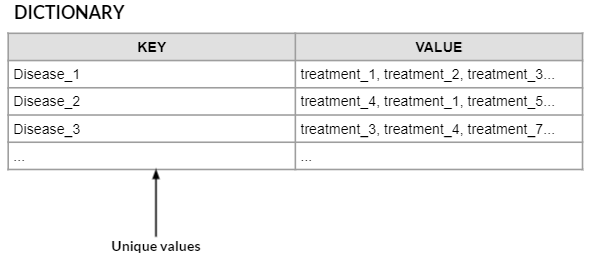

### Below is method which can be used to extract the Disease and Corresponding treament as dictionary from the test dataset and the predicted dataset. 

### It will return a dictionary with Disease as key and List of Treatment as value of the keys. 

In [ ]:
def get_disease_treatments(data):
    d_t_Dict = {}
    treatment_list = []
    for id in range(len(data)):
        #print(id)
        if 'D' in data[id]:
            if 'T' in data[id]:
                matches_idx_t = [i for i in range(0,len(data[id])) if data[id][i]=='T']
                treament = [test_sentences[id][idx][0] for idx in matches_idx_t]

                matches_idx_d = [i for i in range(0,len(data[id])) if data[id][i]=='D']
                disease = [test_sentences[id][idx][0] for idx in matches_idx_d]

                disease = " ".join(disease)
                treament = " ".join(treament)

                if disease in d_t_Dict.keys():
                    d_t_Dict[str(disease)].append(str(treament))
                else:
                    d_t_Dict[str(disease)] = [str(treament)]
    return d_t_Dict

### Below is the dictionary of Disease and correspoding treaments for actual test data

In [ ]:
# Getting the disease and trement dictionary on actual test data
test_disease_treament = get_disease_treatments(y_test)
test_disease_treament

{'renal cell carcinoma': ['Interferon treatment'],
 'odontogenic infections': ['Antimicrobial treatment'],
 'partial seizures': ['lamotrigine monotherapy', 'lamotrigine ( LTG )'],
 'myocardial angiogenesis': ['Gene therapy'],
 "Barrett 's esophagus": ['Acid suppression therapy'],
 'depressive reactions': ['Physiologic treatment'],
 'hydrocele and cysts of the epididymis': ['sclerosing injections of quinine and urea chlorhydrolactate'],
 'autoimmune hemolytic anemia': ['heparin'],
 'endometrial hyperplasia': ['clomiphene citrate'],
 'severe hypertension': ['methyldopa'],
 'epithelial ovarian cancer': ['chemotherapy',
  'High-dose chemotherapy with autologous stem-cell support'],
 "Frontal dysfunction Alzheimer 's disease": ['THA'],
 'sciatica': ['Corticosteroid injections'],
 'stroke brain hemorrhage': ['Antiplatelet therapy atrial fibrillation'],
 'noninsulin-dependent diabetes mellitus': ['troglitazone'],
 "Hodgkin 's disease": ['ABVD MOPP/ABV'],
 'lymphoma': ['Paclitaxel'],
 'renovas

### Below is the dictionary of Disease and correspoding treaments for predictions on test data

In [ ]:
# Getting the disease and trement dictionary on predicted test data
pred_disease_treament = get_disease_treatments(y_pred)
pred_disease_treament

{'renal cell carcinoma': ['Interferon treatment'],
 'partial seizures': ['lamotrigine monotherapy', 'lamotrigine ( LTG )'],
 "Barrett 's esophagus": ['Acid suppression therapy'],
 'autoimmune hemolytic anemia': ['heparin'],
 'severe hypertension': ['methyldopa'],
 'epithelial ovarian cancer': ['chemotherapy',
  'High-dose chemotherapy with autologous stem-cell support'],
 'stroke brain hemorrhage atrial fibrillation': ['Antiplatelet therapy'],
 'diabetes mellitus': ['troglitazone'],
 'lymphoma': ['Paclitaxel'],
 'renovascular hypertension': ['Percutaneous transluminal angioplasty'],
 'benign prostatic hyperplasia': ['surgical resection'],
 'pulmonary hypertension': ['double lung transplantation'],
 'multiple sclerosis': ['Interferon beta treatment',
  'Intravenous immunoglobulin treatment'],
 'acute myocardial infarction': ['thrombolytic treatment',
  'Thrombolytic therapy'],
 'acoustic neuroma': ['Stereotactic radiosurgery'],
 'cerebral palsy': ['Hyperbaric oxygen therapy'],
 'postvit

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
pred_disease_treament['retinoblastoma']

['radiotherapy']

In [ ]:
pred_disease_treament['hereditary retinoblastoma']

KeyError: ignored

### We can in above output that the disease 'hereditary retinoblastoma' is not found in the list of dictionary, as word 'hereditary' is not predicted as 'D' by our model. Since our model has predicted word 'retinoblastoma' as disease, so we can find the treatment for the same and that is 'radiotherapy'